In [1]:
import pandas as pd
import re

# load
df_notes = pd.read_csv('df_430_radiology_notes.csv')

# simple clean: strip extra whitespace, lowercasing, remove non‐printable chars
def clean(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\x20-\x7E]', '', text)
    return text.strip()

df_notes['clean_text'] = df_notes['TEXT'].apply(clean)


In [3]:
import spacy.cli

spacy.cli.download("en_core_web_sm")


import spacy
nlp = spacy.load("en_core_web_sm")



✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
%pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/301.2 kB 330.3 kB/s eta 0:00:01
   ------------------- -------------------- 143.4/301.2 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


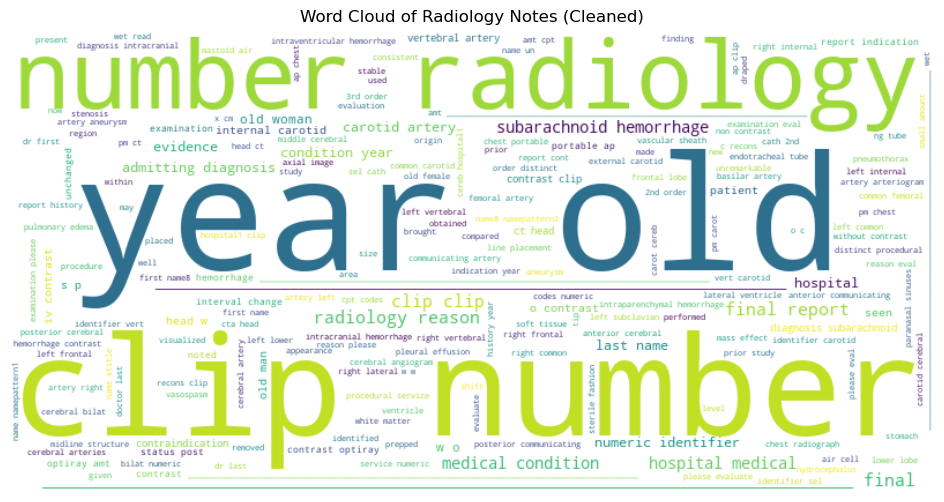

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# assume df_notes['clean_text'] exists
all_text = " ".join(df_notes['clean_text'])
wc = WordCloud(width=800, height=400, background_color="white")\
       .generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Radiology Notes (Cleaned)")
plt.show()

In [7]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm", disable=["parser","tagger","lemmatizer"])
nlp.enable_pipe("ner")

# pick one long note
doc = nlp(df_notes['clean_text'].iloc[0])

# render inline in Jupyter
displacy.render(doc, style="ent", jupyter=True, options={"distance": 100})


In [9]:
%pip install scispacy

Defaulting to user installation because normal site-packages is not writeable
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
   ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
   ---------------------------------------- 46.2/46.2 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/468.1 kB ? eta -:--:--
   ---------------------------------------  460.8/468.1 kB 9.6 MB/s eta 0:00:01
   ---------------------------------------- 468.1/468.1 kB 7.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.7 MB ? eta -:--:--
   -- ------------------------------------- 0.6/11.7 MB 19.8 MB/s eta 0:00:01
   ---- ----------------------------------- 1.3/11.7 MB 13.4 MB/s eta 0:00:01
   ------ --------------------------------- 1.8/11.7 MB 12.5 MB/s eta 0:00:01
   -------- ------------------------------- 2.5/11.7 MB 12.3 MB/s eta 0:00:01
   ------------ --------------------------- 3.6/11.7 MB 13.6 MB/s eta 0:00:01
   --------------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [18]:
%pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz




Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/119.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/119.8 MB ? eta -:--:--
     -------------------------------------- 0.1/119.8 MB 825.8 kB/s eta 0:02:25
     ---------------------------------------- 0.2/119.8 MB 1.4 MB/s eta 0:01:25
     ---------------------------------------- 0.4/119.8 MB 2.1 MB/s eta 0:00:56
     ---------------------------------------- 0.6/119.8 MB 2.7 MB/s eta 0:00:45
     ---------------------------------------- 0.8/119.8 MB 2.8 MB/s eta 0:00:42
      --------------------------------------- 1.5/119.8 MB 4.6 MB/s eta 0:00:26
      --------------------------------------- 2.4/119.8 MB 6.5 MB/s eta 0:00:19
     - -------------------------------------- 3.7/119.8 MB 8.6 MB/s eta 0:00:14
     - ------------------------------------- 4.9/119.8 MB 10.5 MB/s eta 0:00:11
     -- ------------------------------------ 6.4/119.8 M

In [19]:
import spacy

# load the BC5-CDR disease+chemical model
nlp_bc5 = spacy.load("en_ner_bc5cdr_md")

# test on one note
doc = nlp_bc5(df_notes['clean_text'].iloc[0])
print([(ent.text, ent.label_) for ent in doc.ents])


C:\Users\aaron\AppData\Roaming\Python\Python312\site-packages\spacy\util.py:922: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.7). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  def get_model_meta(path: Union[str, Path]) -> Dict[str, Any]:
C:\Users\aaron\AppData\Roaming\Python\Python312\site-packages\spacy\language.py:2233: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


[('l-spine', 'CHEMICAL'), ('fracture', 'DISEASE'), ('dementia', 'DISEASE'), ('ich,', 'DISEASE'), ('constipation', 'DISEASE'), ('fracture', 'DISEASE'), ('compression fracture', 'DISEASE'), ('compression fracture', 'DISEASE'), ("paget's disease", 'DISEASE')]


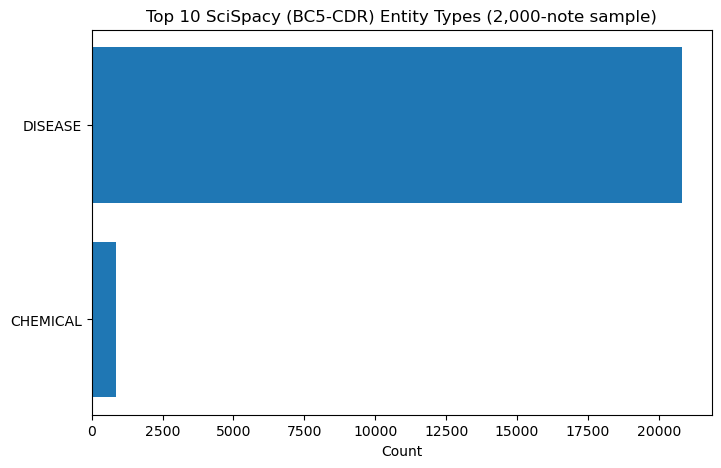

In [21]:
import spacy
import scispacy
from scispacy.linking import EntityLinker
from collections import Counter
import matplotlib.pyplot as plt

# load the BC5-CDR disease+chemical model instead of "en_core_sci_sm"
nlp_clin = spacy.load("en_ner_bc5cdr_md", disable=["parser","tagger","lemmatizer"])

# 6) Sample a subset for speed (reproducible)
sample_df     = df_notes.sample(2000, random_state=42)
sample_texts  = sample_df['clean_text'].tolist()

# 7) Run the model on the sample
docs_clin = list(nlp_clin.pipe(sample_texts, batch_size=200))

# 8) Count entity labels
labels = [ent.label_ for doc in docs_clin for ent in doc.ents]
top10  = Counter(labels).most_common(10)
types, counts = zip(*top10)

# 9) Plot the top-10 entity types
plt.figure(figsize=(8,5))
plt.barh(types, counts)
plt.xlabel("Count")
plt.title("Top 10 SciSpacy (BC5-CDR) Entity Types (2,000-note sample)")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# 2) Imports
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

# 3) Prepare a 5 000-note sample of your cleaned text
sentences = [text.split() for text in df_notes['clean_text'].sample(5000, random_state=42)]

# 4) Train Word2Vec on that subset
w2v = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    epochs=5
)

# 5) Find the top-10 neighbors of “stroke”
seed = "stroke"
neighbors = w2v.wv.most_similar(seed, topn=10)
words, sims = zip(*neighbors)

# 6) Plot the results
plt.figure(figsize=(6,4))
plt.barh(words, sims)
plt.xlabel("Cosine similarity")
plt.title(f"Top 10 words similar to “{seed}” – Word2Vec on 5 000 notes")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# average word-vec per note
def avg_vec(tokens):
    vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
    return np.mean(vecs,axis=0) if vecs else np.zeros(w2v.vector_size)

X = np.vstack(df_notes['clean_text'].str.split().map(avg_vec).values)
X2 = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X2[:,0], X2[:,1], s=5, alpha=0.6)
plt.title("t-SNE of Radiology-note Embeddings")
plt.xlabel("TSNE-1"); plt.ylabel("TSNE-2")
plt.show()


NameError: name 'w2v' is not defined

In [ ]:
%pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model     = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def get_bert_emb(text):
    inputs = tokenizer(text, truncation=True, padding="max_length", max_length=256, return_tensors="pt")
    with torch.no_grad():
        out = model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()
    return out

# compute on a 5k-note sample for speed
sample = df_notes['clean_text'].sample(5000, random_state=0).tolist()
Emb = np.vstack([get_bert_emb(t) for t in sample])
Emb2 = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(Emb)

plt.figure(figsize=(8,6))
plt.scatter(Emb2[:,0], Emb2[:,1], s=5, alpha=0.6)
plt.title("t-SNE of ClinicalBERT Note Embeddings (5k sample)")
plt.show()
